# VARIATIONAL AUTOENCODER

Data Preprocessing

In [ ]:
import numpy as np
from tensorflow.keras import datasets
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
def preprocess(imgs): #normalize and reshapr the images
  imgs = imgs.astype("float32") / 255.0
  imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2) ), constant_values=0.0)
  imgs = np.expand_dims(imgs, -1)
  return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, metrics, backend as K
from tensorflow.keras.losses import binary_crossentropy

In [ ]:
class Sampling(layers.Layer): #subclass creation
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape= (batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Encoder


In [ ]:
encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")

x = layers.Conv2D(filters=32, kernel_size=(3,3), strides = 2, activation="relu", padding ="same")(encoder_input)
x = layers.Conv2D(filters=64, kernel_size=(3,3),  strides = 2, activation="relu", padding ="same")(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3),  strides = 2, activation="relu", padding ="same")(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)

z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 32)     │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          4,098 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          4,098 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

Ploting the Neural Network Architecture

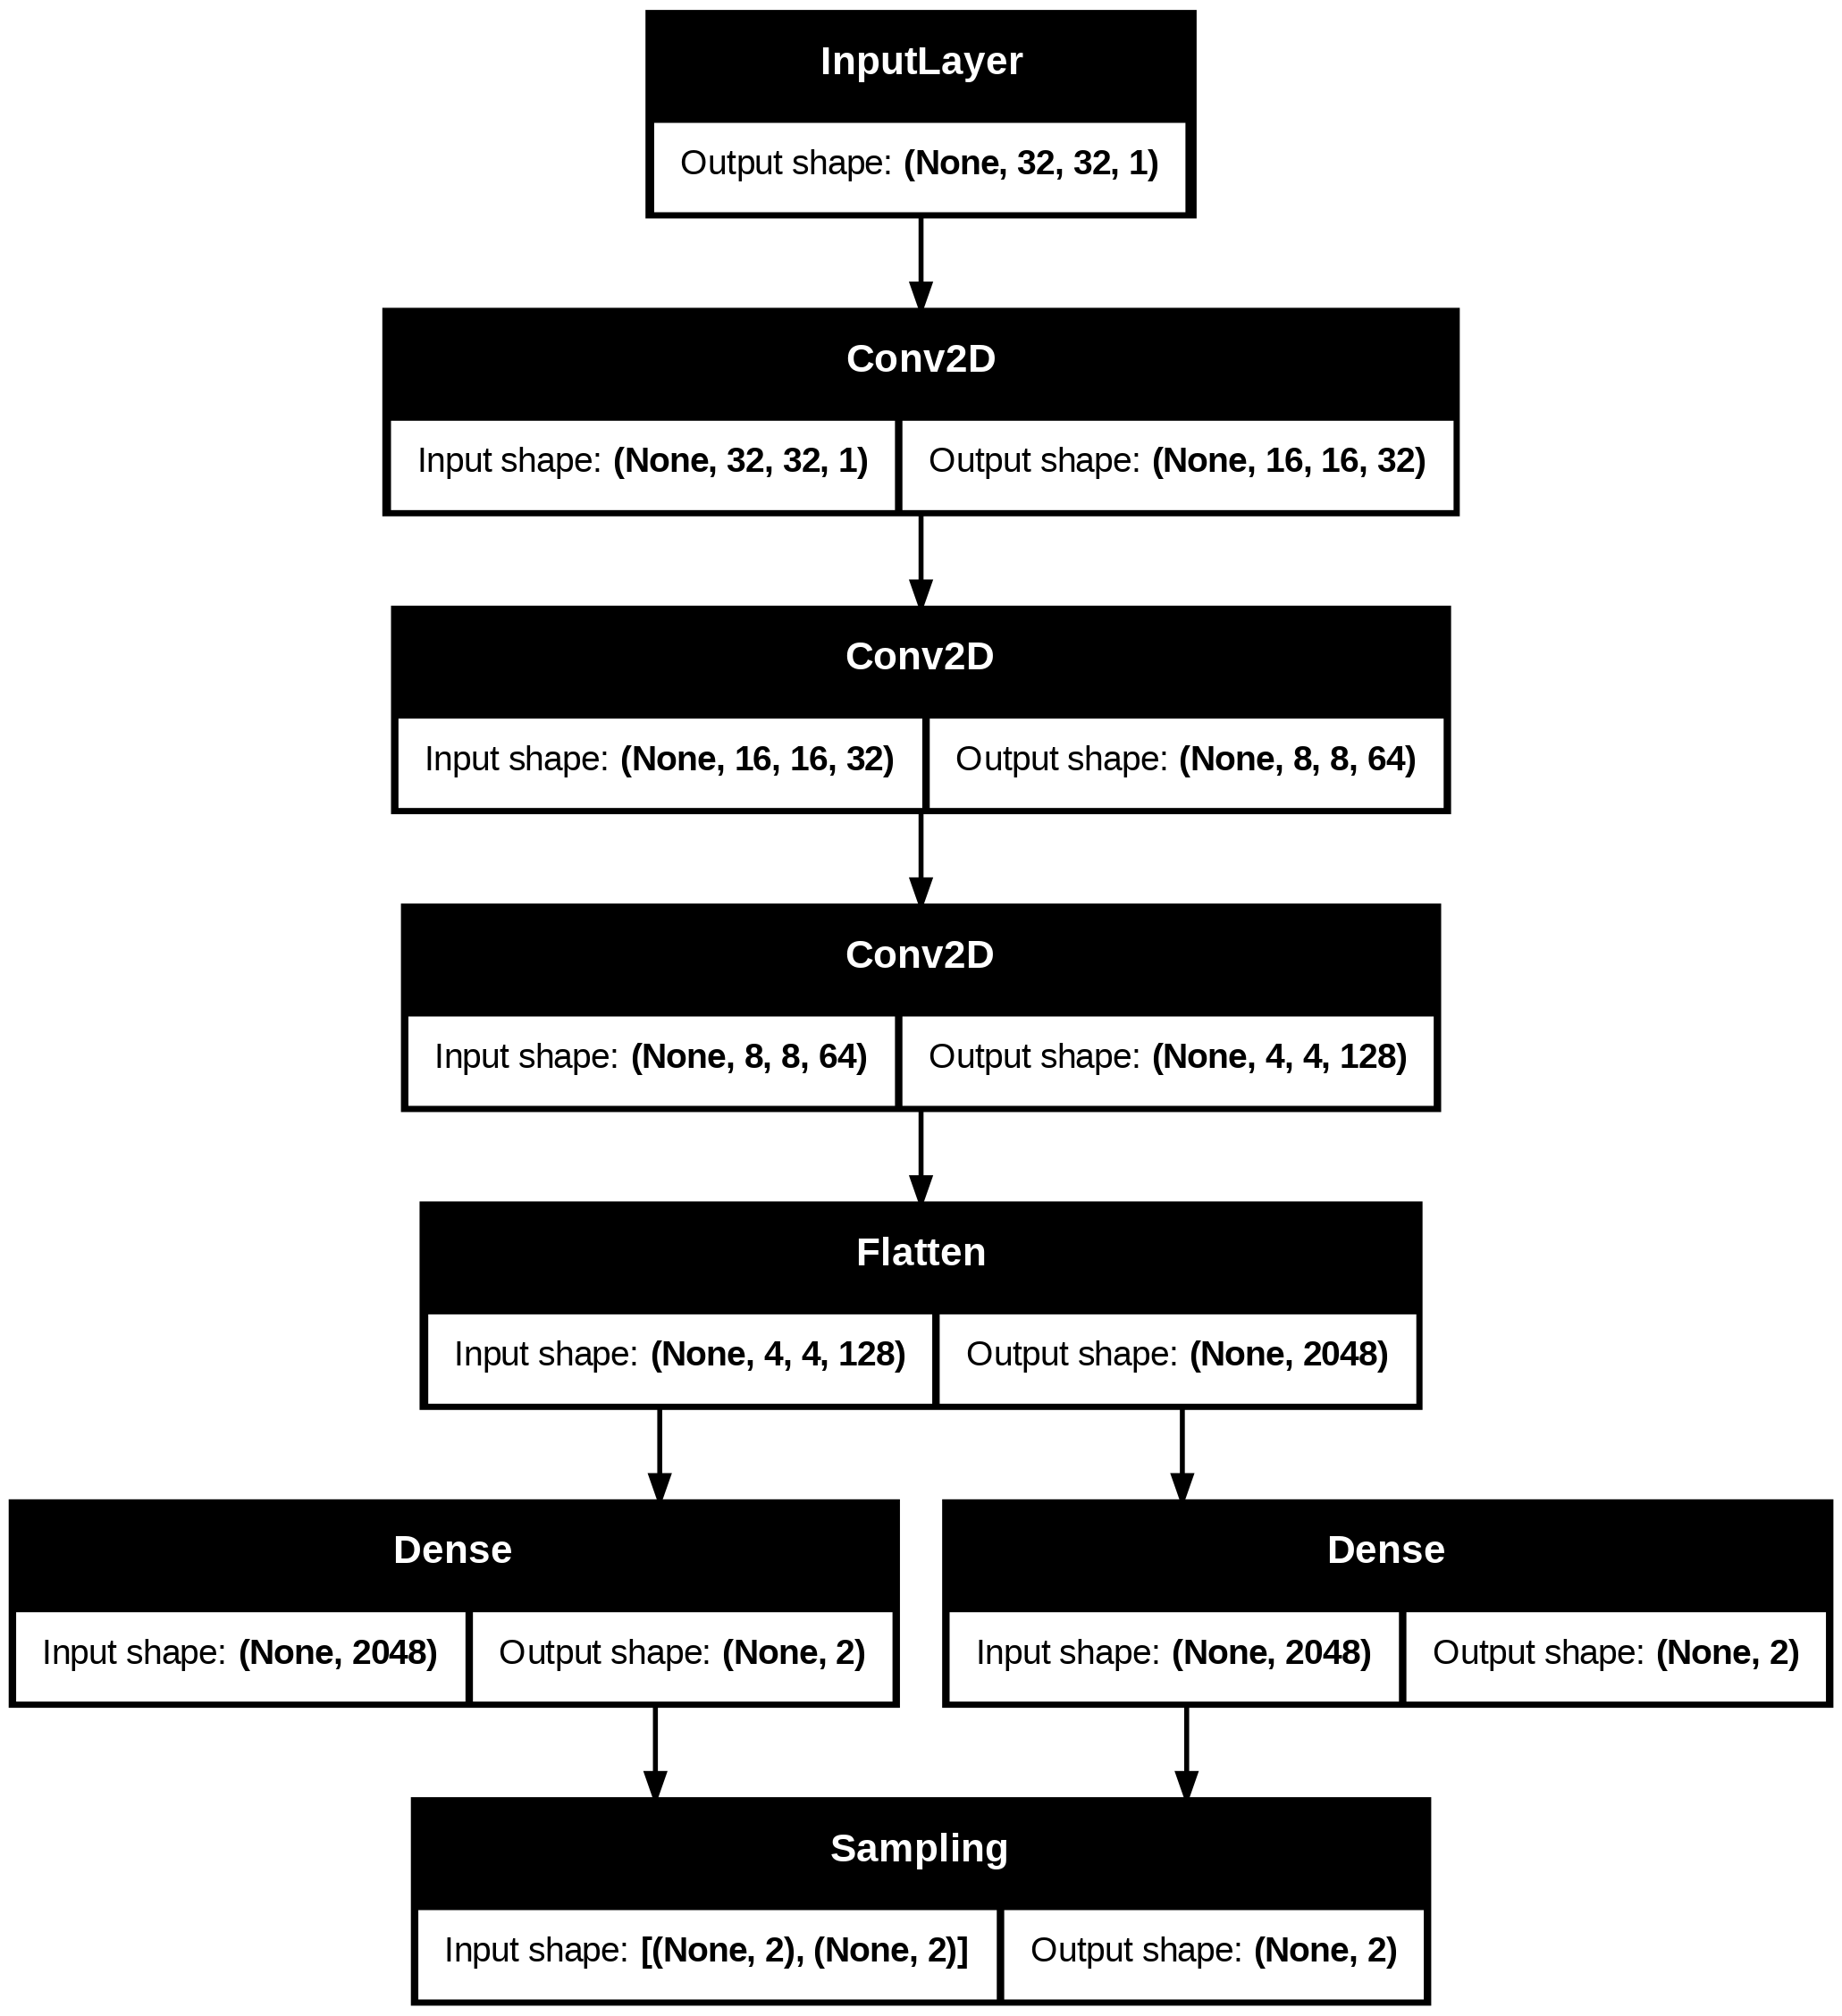

In [ ]:
from keras.utils import plot_model
plot_model(encoder, to_file='model_architecture.png', show_shapes = True)

In [ ]:
#define a custom layer to caluclate the KL loss
class KLLossLayer(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    kl_loss = -0.5 * tf.reduce_sum(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis = -1
    )
    return kl_loss

kl_loss = KLLossLayer()([z_mean, z_log_var])

Decoder

In [ ]:
from tensorflow.keras.models import Model

decoder_input = layers.Input(shape=(2, ), name="decoder_input")

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)

x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, (3,3), strides = 2, activation="relu", padding ="same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides = 2, activation="relu", padding ="same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides = 2, activation="relu", padding ="same")(x)

decoder_output = layers.Convolution2D(1, (3, 3), strides= 1, activation="sigmoid", padding="same", name= "decoder_output")(x)

decoder = Model(decoder_input, decoder_output)

In [ ]:
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow import metrics
class VAE(models.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
      self.total_loss_tracker,
      self.reconstruction_loss_tracker,
      self.kl_loss_tracker,
    ]

  def call(self, inputs):
    z_mean, z_log_var, z = self.encoder(inputs)
    reconstruction = self.decoder(z)
    return z_mean, z_log_var, reconstruction

  def train_step(self, data):
    with tf.GradientTape() as tape: #Fixed typo GradiantTape to GradientTape
      z_mean, z_log_var, reconstruction = self(data)
      reconstruction_loss = 500 * tf.reduce_mean(
          binary_crossentropy(data, reconstruction)  )
      kl_loss = tf.reduce_mean(
          tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis = 1)
      )
      total_loss = reconstruction_loss + kl_loss #Fixed typo reconstructions_loss to reconstruction_loss
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      return {m.name: m.result() for m in self.metrics}

#assuming the decoder model is defined elsewhere

vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(
    x_train,
    epochs=5,
    batch_size=100
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 213s 349ms/step - kl_loss: 3.9703 - reconstruction_loss: 178.2555 - total_loss: 182.2258
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 209s 349ms/step - kl_loss: 4.9352 - reconstruction_loss: 130.2427 - total_loss: 135.1780
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 262s 348ms/step - kl_loss: 5.0348 - reconstruction_loss: 128.4212 - total_loss: 133.4560
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 208s 347ms/step - kl_loss: 5.1097 - reconstruction_loss: 127.3849 - total_loss: 132.4947
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 261s 345ms/step - kl_loss: 5.1445 - reconstruction_loss: 126.6289 - total_loss: 131.7733


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


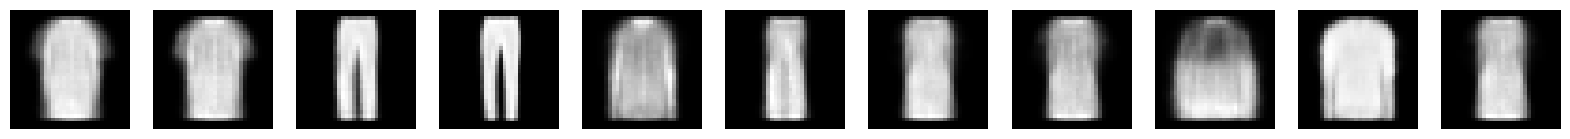

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#assuming the decoder is already defined and trained

latent_dim = 2

#function to generate new images
def generate_new_images(decoder, num_images=10):

  #sample random points from a normal distribution
  random_latent_vectors = np.random.normal(size=(num_images, latent_dim))

   #decode the latent vectors to generate new images
  generated_images = decoder.predict(random_latent_vectors)

   #plot the generated images
  plt.figure(figsize=(20,4))
  for i in range(num_images):
    ax = plt.subplot(1, num_images, i+1)
    plt.imshow(generated_images[i].reshape(32,32), cmap='gray')
    plt.axis('off')
  plt.show()

#generate and display new images
generate_new_images(decoder, num_images=11)